In [1]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
import requests 
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# IF the image folder doesn't exist download it and prepare it
if image_path.is_dir():
    print(f"{image_path} dir already exist... skipping download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    # request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizaa, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizaa, steak and sushi data...")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi dir already exist... skipping download
Unzipping pizaa, steak and sushi data...


In [3]:
# Becoming one with the data ( data preparation and data exploration)

import os
def walk_through_dir(dir_path):
    """Walks through dir_path its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}''")
print(image_path)
walk_through_dir(image_path)

data\pizza_steak_sushi
There are 2 directories and 0 images in 'data\pizza_steak_sushi''
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test''
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza''
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak''
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi''
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train''
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza''
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak''
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi''


In [4]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. Show the image and print metadata

Random image_path: data\pizza_steak_sushi\train\pizza\1412034.jpg
Image class: pizza
Image hieght: 512
Image width: 512


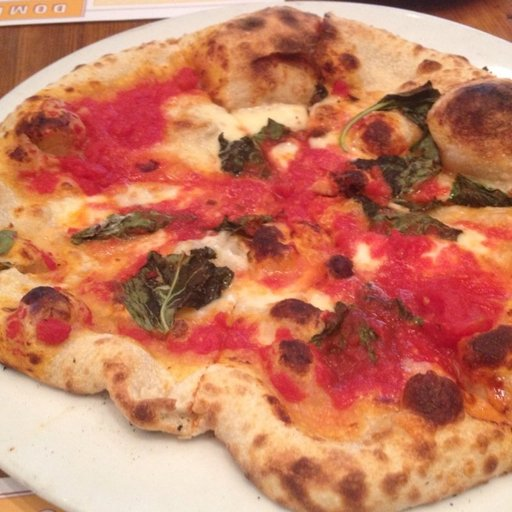

In [5]:
import random
from PIL import Image

# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the iamge class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image_path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image hieght: {img.height}")
print(f"Image width: {img.width}")
img

<class 'numpy.ndarray'>


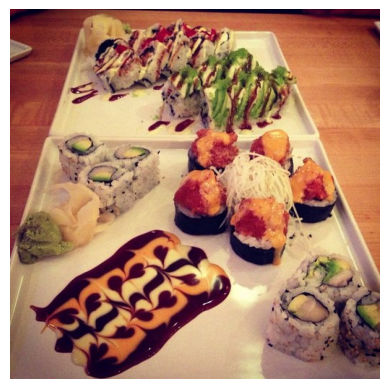

In [6]:
## Visualizing image using matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# loading image
rand_image = mpimg.imread(random.choice(image_path_list))
print(type(rand_image))

plt.imshow(rand_image)
plt.axis(False)
plt.show()

(-0.5, 511.5, 511.5, -0.5)

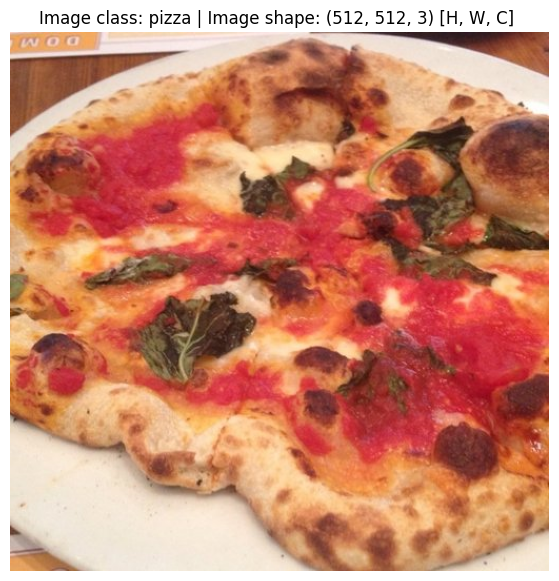

In [7]:
import numpy as np

# Turn the image into an array
img_as_array = np.asarray(img)

# plot the image with matplolib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} [H, W, C] ")
plt.axis(False)

# 3. Transforming data (into tensors)

1. Turn the target data into tensors
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoder`.

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 3.1 Transforming data with torchvision.transforms

In [9]:
# Write a transform for iamge
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(128, 128)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [10]:
data_transform(img).shape

torch.Size([3, 128, 128])

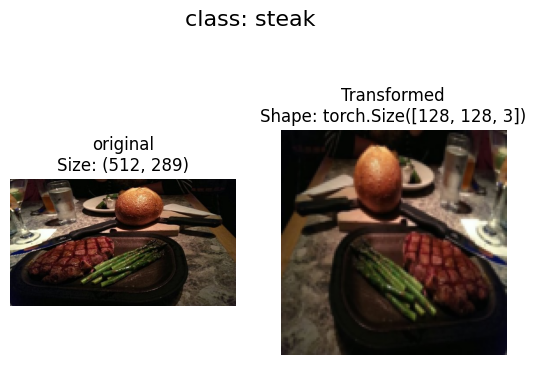

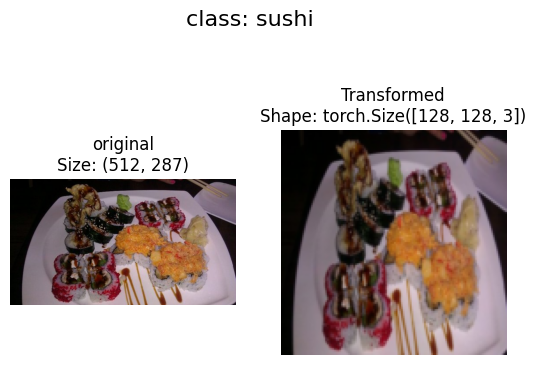

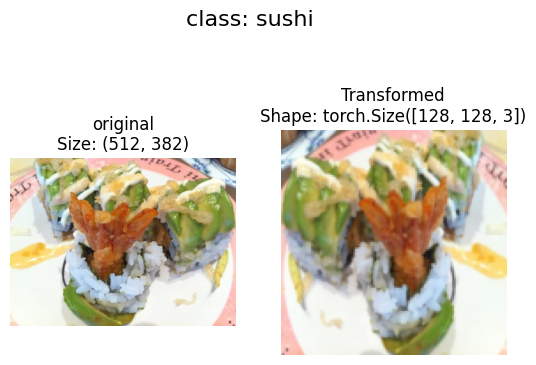

In [11]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    """
    Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"original\nSize: {f.size}")
            ax[0].axis(False)
        
            # Transform an plot target image
            transformed_image = transform(f).permute(1,2,0) # Note we need to chage shape for matplotlib
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

        fig.suptitle(f"class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                       transform=data_transform,
                       n=3,
                       seed=None)

# 4. Option 1: Loading image data suing `ImageFolder`

In [12]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                 transform=data_transform, # a transform for the data
                                 target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [13]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
len(train_data), len(test_data)

(225, 75)

In [16]:
train_data.samples[:5]

[('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0),
 ('data\\pizza_steak_sushi\\train\\pizza\\1033251.jpg', 0),
 ('data\\pizza_steak_sushi\\train\\pizza\\1044789.jpg', 0),
 ('data\\pizza_steak_sushi\\train\\pizza\\1089334.jpg', 0),
 ('data\\pizza_steak_sushi\\train\\pizza\\1105700.jpg', 0)]

In [17]:
img, label = train_data[0][0], train_data[0][1]
class_names[label], img.shape

('pizza', torch.Size([3, 128, 128]))

Original shape: torch.Size([3, 128, 128])
Image permute: tensor([[[0.1137, 0.0588, 0.0196],
         [0.1098, 0.0549, 0.0196],
         [0.1098, 0.0549, 0.0196],
         ...,
         [0.1059, 0.0706, 0.0902],
         [0.1137, 0.0745, 0.0980],
         [0.1137, 0.0706, 0.0941]],

        [[0.1255, 0.0627, 0.0235],
         [0.1216, 0.0627, 0.0235],
         [0.1216, 0.0627, 0.0235],
         ...,
         [0.1059, 0.0745, 0.0902],
         [0.1098, 0.0706, 0.0941],
         [0.1137, 0.0745, 0.0941]],

        [[0.1333, 0.0667, 0.0196],
         [0.1294, 0.0627, 0.0157],
         [0.1294, 0.0627, 0.0196],
         ...,
         [0.1020, 0.0745, 0.0902],
         [0.1059, 0.0745, 0.0941],
         [0.1098, 0.0745, 0.0941]],

        ...,

        [[0.1765, 0.2314, 0.1843],
         [0.1686, 0.2275, 0.1765],
         [0.1647, 0.2275, 0.1765],
         ...,
         [0.0902, 0.1098, 0.1059],
         [0.0863, 0.1098, 0.1098],
         [0.0824, 0.1059, 0.1059]],

        [[0.1765, 0.2314,

Text(0.5, 1.0, 'pizza')

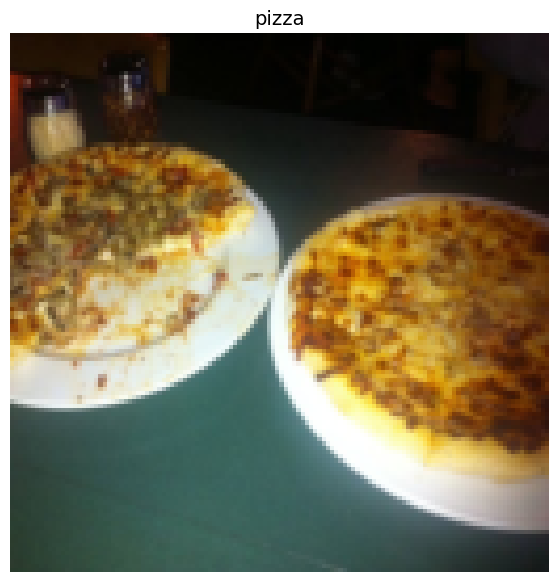

In [18]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape}")
print(f"Image permute: {img_permute}")

# plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

## 4.1 Turn Loaded images into `DataLoader`s

In [19]:
# Turn train and test dtasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE=16
train_dataloader = DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             num_workers=3,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           num_workers=3,
                           shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1d5e2071640>,
 <torch.utils.data.dataloader.DataLoader at 0x1d5e20facc0>)

In [20]:
len(train_dataloader), len(test_dataloader)

(15, 5)

In [21]:
img, label = next(iter(train_dataloader))

print(f"image shape: {img.shape} --> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

image shape: torch.Size([16, 3, 128, 128]) --> [batch_size, color_channels, height, width]
Label shape: torch.Size([16])


# 5. Option 2: Loading Image data with a Custom `Dataset`

1. want to be able to laod images from file
2. want to be able to get class names from the Dataset
3. want to be able to get classes as dictionary from Dataset

In [22]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [23]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [24]:
# Setup path for target dir
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [25]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Find the class folder names in a target directory."""
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in list(os.scandir(target_directory)) if entry.is_dir())

    # 2. Raise and error if class anmes could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... Please check file structure.")

    # 3. Create a dict of index labels (computers prefers numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [26]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [27]:
# 0. Write a custom dataset class
from  torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # Initialize our custom dataset
    def __init__(self, targ_dir: str, transform=None) -> None:
        # 3. Create class attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transform
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)
        
    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite __len()__
    def __len__(self) -> int:
        "Return the total number of samples."
        return len(self.paths)

    # 6. Overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returs one sample of data, data anmd label (X, y)."
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # Expects path in format: data_folder/class_name/img.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return untransformed image label

In [28]:
# Create a transofrm 
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose({
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor()
})

In [29]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                     transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                    transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1d5e25cc770>,
 <__main__.ImageFolderCustom at 0x1d5e259d7c0>)

In [30]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [31]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [32]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [33]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


In [34]:
# Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                         seed: int = None):
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape: False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop thorough samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

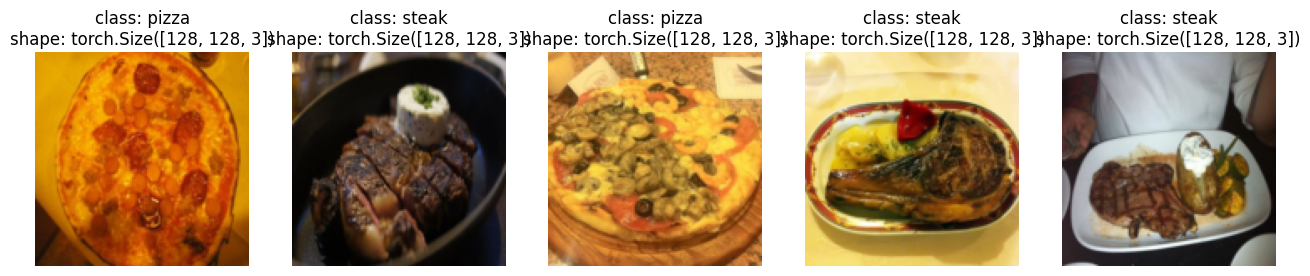

In [35]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                     n=5,
                     classes=class_names,
                     seed=None)

In [36]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                   batch_size=1,
                                   num_workers=0,
                                   shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x1d5e21326f0>,
 <torch.utils.data.dataloader.DataLoader at 0x1d5e21302f0>)

In [37]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 128, 128]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# 6. Other forms of transforms (data augmentation)

In [38]:
# using trivialaugment from torchvision

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [39]:
# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

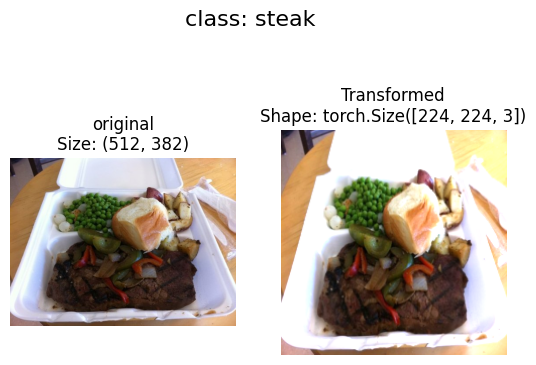

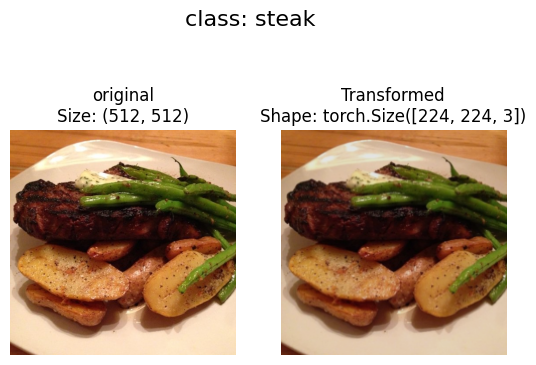

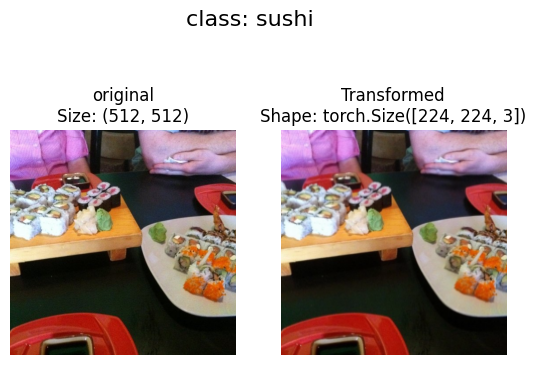

In [40]:
# PLot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

# 7. Model 0: TinyVGG without data augmentation

## 7.1 Creating transforms and laoding data for Model 0

In [41]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])


In [42]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                        transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                       transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple)

In [43]:
NUM_WORKERS

12

## 7.2 Create TinyVGG model class

In [44]:
class TinyVGG(nn.Module):
    """
    CNN Explainer website model architechture
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),

            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2) # default stride values is same as kernel_size
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),

            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2) # default stride values is same as kernel_size
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13, out_features=output_shape)
        )

    def forward(self, x):
        # x = self.conv_block_1(x)
        # print(x.shape)
        # x = self.conv_block_2(x)
        # print(x.shape)
        # x = self.classifier(x)
        # print(x.shape)
        # return x

        # pro programmers ^^
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion
        
        

In [45]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

## 7.3 Try a forward pass on a single image(to test the model)

In [46]:
# Get a single image batch
image_batch, label_batch = next (iter(train_dataloader_simple))
image_batch.shape, label, label_batch.shape


(torch.Size([32, 3, 64, 64]),
 tensor([1, 2, 1, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 1, 2, 0]),
 torch.Size([32]))

In [47]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9128e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6416e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0238e-02, -4.7978e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1817e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1470e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1013e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

## 7.4 Use `torch.info` to get an idea of the shapes going through our model

In [48]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Create train and test loops functions
* `train_step()`
* `test_step()`

In [49]:
def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device=device):
    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass 
        y_pred = model(X) # output model logits

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and average acc per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [50]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    model.eval()

    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))
        # adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [51]:
from tqdm import tqdm

def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
         epochs: int =5,
         device=device):
    results = {"train_loss": [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)
        # Print out what's happenin'
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

## 7.7 Model 0 evaluation

In [53]:
# Set number of epochs
NUM_EPOCHS = 10

#Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                       train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 10%|████████▎                                                                          | 1/10 [00:05<00:48,  5.38s/it]

Epoch: 0 | Train loss: 1.0936 | Train acc: 0.39 | Test loss: 1.1056 | Test acc: 0.33


 20%|████████████████▌                                                                  | 2/10 [00:10<00:42,  5.29s/it]

Epoch: 1 | Train loss: 1.1146 | Train acc: 0.30 | Test loss: 1.1051 | Test acc: 0.33


 30%|████████████████████████▉                                                          | 3/10 [00:15<00:36,  5.27s/it]

Epoch: 2 | Train loss: 1.1120 | Train acc: 0.30 | Test loss: 1.1082 | Test acc: 0.33


 40%|█████████████████████████████████▏                                                 | 4/10 [00:21<00:31,  5.25s/it]

Epoch: 3 | Train loss: 1.0935 | Train acc: 0.43 | Test loss: 1.0984 | Test acc: 0.33


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:26<00:26,  5.24s/it]

Epoch: 4 | Train loss: 1.0877 | Train acc: 0.43 | Test loss: 1.0951 | Test acc: 0.33


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:31<00:20,  5.19s/it]

Epoch: 5 | Train loss: 1.1030 | Train acc: 0.30 | Test loss: 1.0978 | Test acc: 0.33


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:36<00:15,  5.19s/it]

Epoch: 6 | Train loss: 1.0982 | Train acc: 0.30 | Test loss: 1.0850 | Test acc: 0.33


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:41<00:10,  5.21s/it]

Epoch: 7 | Train loss: 1.0791 | Train acc: 0.37 | Test loss: 1.0824 | Test acc: 0.36


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:47<00:05,  5.20s/it]

Epoch: 8 | Train loss: 1.0599 | Train acc: 0.51 | Test loss: 1.0549 | Test acc: 0.47


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.22s/it]

Epoch: 9 | Train loss: 1.0327 | Train acc: 0.54 | Test loss: 1.0603 | Test acc: 0.35
Total training time: 52.208 seconds


## 7.8 Plot the loss curves of Model 0
- A *loss curve* is a way of tracking our model's progress over time

In [56]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [57]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plot training curves of a results dictionary."""
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure aout how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();
    

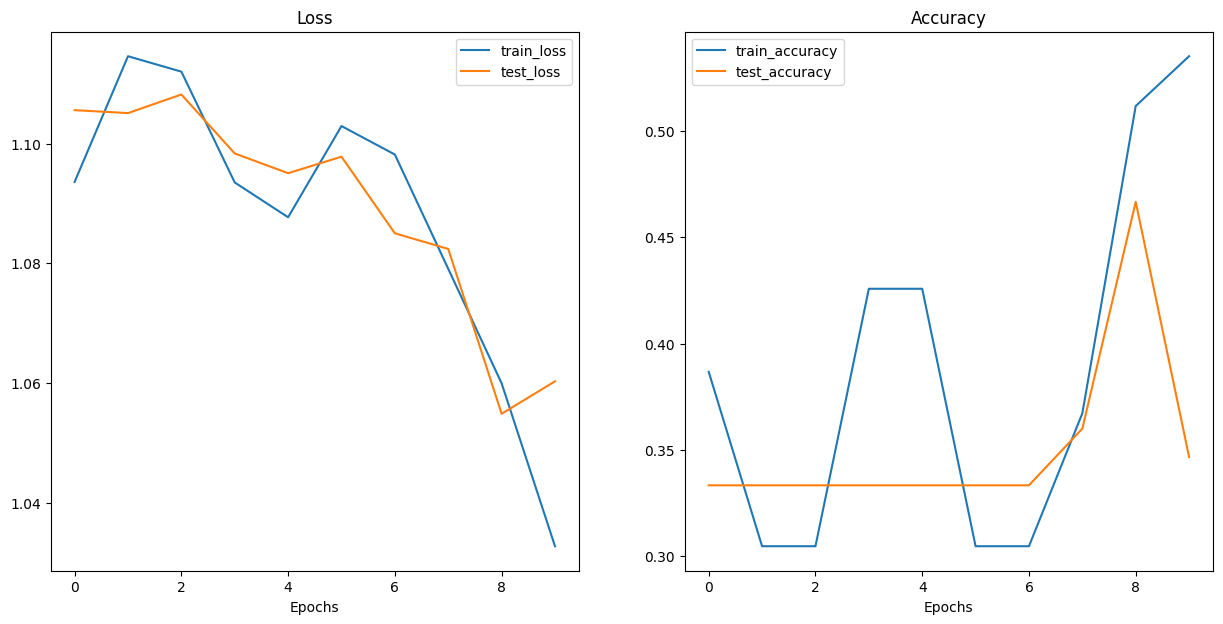

In [58]:
plot_loss_curves(model_0_results)

# Building TinyVGG Model vaersion 1 with Data Augmentation

In [62]:
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

## Create traind and test Datasets and DataLoaders with data augmentation


In [64]:
# Turn image fodlers into Datasets
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                           transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                       transform=test_transform_simple)

In [67]:
# turn Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   num_workers=NUM_WORKERS)


In [69]:
train_data_augmented

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )

## Construct and train model

In [70]:
model_1 = TinyVGG(input_shape = 3 , hidden_units=10, output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [88]:
NUM_EPOCHS = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                       train_dataloader=train_dataloader_augmented,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer,
                       loss_fn = loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

end_time = timer()
print(f"Total training timer for model_1: {end_time-start_time:.3f} seconds")

 10%|████████▎                                                                          | 1/10 [00:09<01:29,  9.97s/it]

Epoch: 0 | Train loss: 1.1169 | Train acc: 0.44 | Test loss: 1.0561 | Test acc: 0.38


 20%|████████████████▌                                                                  | 2/10 [00:19<01:20, 10.01s/it]

Epoch: 1 | Train loss: 0.9648 | Train acc: 0.57 | Test loss: 0.9585 | Test acc: 0.53


 30%|████████████████████████▉                                                          | 3/10 [00:29<01:09,  9.98s/it]

Epoch: 2 | Train loss: 1.0726 | Train acc: 0.36 | Test loss: 0.9561 | Test acc: 0.58


 40%|█████████████████████████████████▏                                                 | 4/10 [00:39<00:59,  9.91s/it]

Epoch: 3 | Train loss: 0.9560 | Train acc: 0.53 | Test loss: 1.0084 | Test acc: 0.37


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:49<00:49,  9.94s/it]

Epoch: 4 | Train loss: 1.0638 | Train acc: 0.47 | Test loss: 1.0638 | Test acc: 0.35


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:59<00:39,  9.93s/it]

Epoch: 5 | Train loss: 1.0123 | Train acc: 0.42 | Test loss: 1.0977 | Test acc: 0.33


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:09<00:29,  9.91s/it]

Epoch: 6 | Train loss: 0.9914 | Train acc: 0.47 | Test loss: 1.0831 | Test acc: 0.35


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:19<00:19,  9.87s/it]

Epoch: 7 | Train loss: 0.9900 | Train acc: 0.56 | Test loss: 1.0730 | Test acc: 0.35


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:29<00:09,  9.88s/it]

Epoch: 8 | Train loss: 1.0050 | Train acc: 0.46 | Test loss: 1.0430 | Test acc: 0.34


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:39<00:00,  9.94s/it]

Epoch: 9 | Train loss: 0.9998 | Train acc: 0.48 | Test loss: 1.0948 | Test acc: 0.40
Total training timer for model_1: 99.380 seconds


In [89]:
model_1_results

{'train_loss': [1.1169294640421867,
  0.9648319557309151,
  1.0725705921649933,
  0.955970861017704,
  1.0638271644711494,
  1.0122907757759094,
  0.9914256185293198,
  0.9899846687912941,
  1.0049667656421661,
  0.9998374730348587],
 'train_acc': [0.4375,
  0.5703125,
  0.35546875,
  0.52734375,
  0.47265625,
  0.421875,
  0.46875,
  0.5625,
  0.4609375,
  0.484375],
 'test_loss': [1.0560720960299175,
  0.9584900339444479,
  0.9561380942662557,
  1.008374313513438,
  1.063823640346527,
  1.0977425177892048,
  1.0830616354942322,
  1.0729760924975078,
  1.0430378516515095,
  1.0948464274406433],
 'test_acc': [0.3835227272727273,
  0.5331439393939394,
  0.5833333333333334,
  0.3731060606060606,
  0.3522727272727273,
  0.3333333333333333,
  0.35321969696969696,
  0.35321969696969696,
  0.3418560606060606,
  0.4034090909090909]}

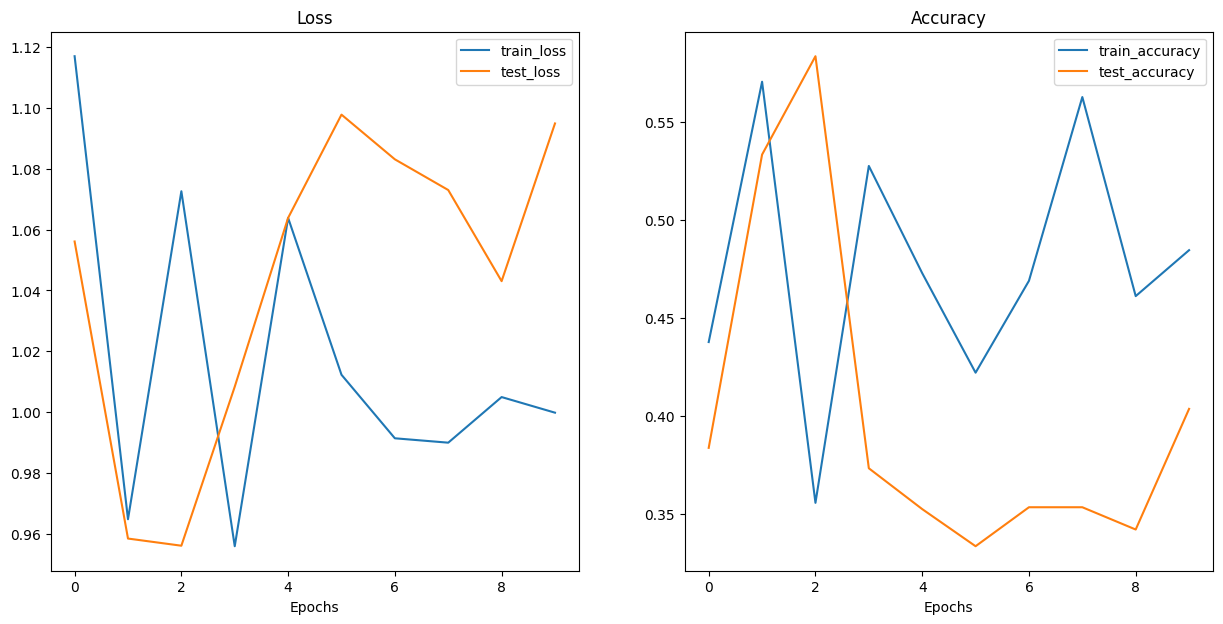

In [90]:
plot_loss_curves(model_1_results)

In [91]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.093608   0.386719   1.105607  0.333333
1    1.114623   0.304688   1.105115  0.333333
2    1.112044   0.304688   1.108226  0.333333
3    1.093518   0.425781   1.098366  0.333333
4    1.087702   0.425781   1.095071  0.333333
5    1.102952   0.304688   1.097825  0.333333
6    1.098187   0.304688   1.085023  0.333333
7    1.079084   0.367188   1.082407  0.360000
8    1.059945   0.511719   1.054852  0.466667
9    1.032710   0.535156   1.060272  0.346667

In [92]:
model_1_df

train_loss  train_acc  test_loss  test_acc
0    1.116929   0.437500   1.056072  0.383523
1    0.964832   0.570312   0.958490  0.533144
2    1.072571   0.355469   0.956138  0.583333
3    0.955971   0.527344   1.008374  0.373106
4    1.063827   0.472656   1.063824  0.352273
5    1.012291   0.421875   1.097743  0.333333
6    0.991426   0.468750   1.083062  0.353220
7    0.989985   0.562500   1.072976  0.353220
8    1.004967   0.460938   1.043038  0.341856
9    0.999837   0.484375   1.094846  0.403409

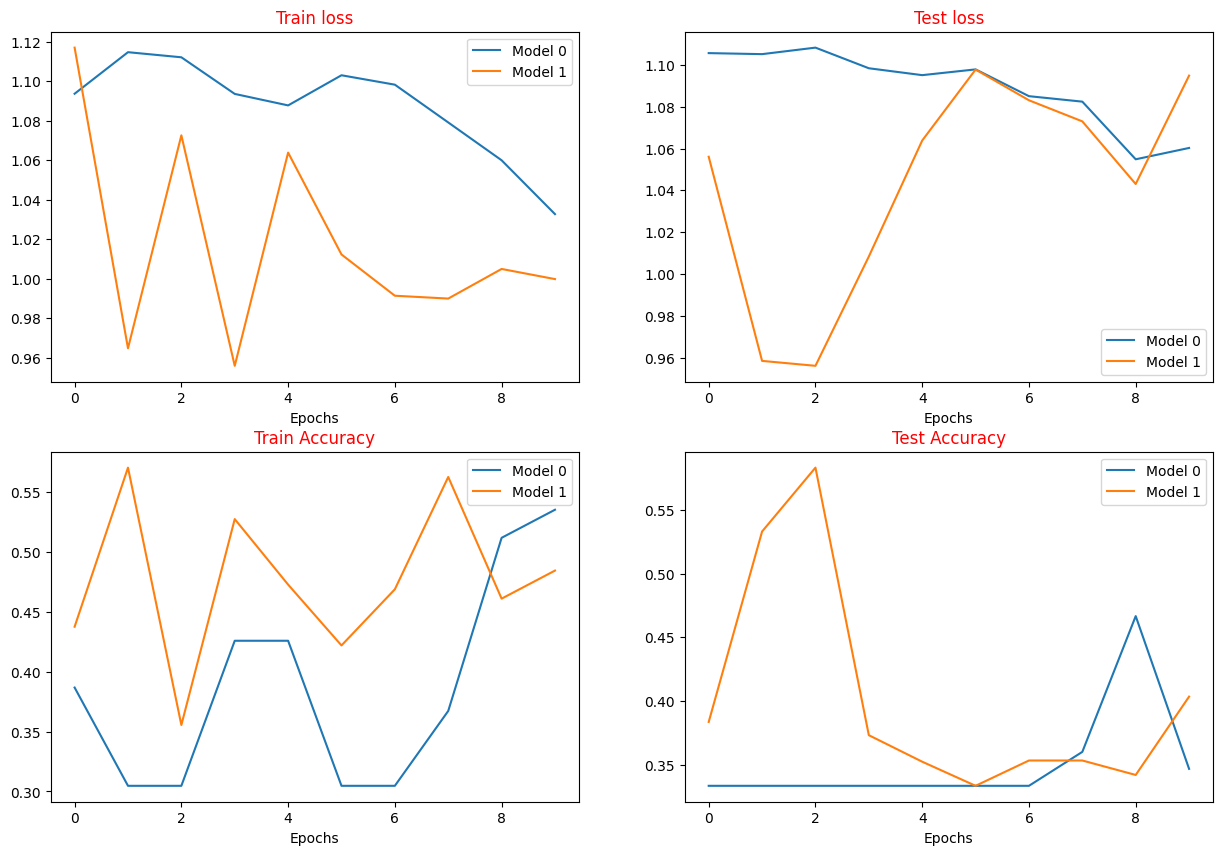

In [97]:
# Setup a plot
plt.figure(figsize=(15, 10))

# get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train loss", color='r')
plt.xlabel("Epochs")
plt.legend();

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test loss", color='r')
plt.xlabel("Epochs")
plt.legend();

# Plot Train acc
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy", color='r')
plt.xlabel("Epochs")
plt.legend();

# Plot test loss
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy", color='r')
plt.xlabel("Epochs")
plt.legend();

## Making a prediction on a custom image

* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the iamge was the same shape as the data the model was trained on (3, 64, 64) with a batch size... (1, 3, 64, 64)
* Make sure the image was on the same device as the trained model

In [105]:
# Download custom image
import requests

custom_image_path = data_path / "pizza_img.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://as2.ftcdn.net/v2/jpg/01/80/49/35/1000_F_180493524_S8JpIi9hBAQ8Bap9TMEhijljBQI4Jskb.jpg")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download....")

data\pizza_img.jpeg already exists, skipping download....


In [111]:
type(str(custom_image_path))

str

In [120]:
### Loading in a custom image with PyTorch
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor: \n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")

Custom image tensor: 
 tensor([[[20, 22, 24,  ..., 48, 48, 46],
         [22, 22, 23,  ..., 49, 47, 46],
         [23, 22, 22,  ..., 51, 49, 47],
         ...,
         [76, 79, 78,  ..., 82, 75, 64],
         [75, 79, 79,  ..., 83, 77, 65],
         [74, 78, 79,  ..., 83, 78, 67]],

        [[25, 27, 29,  ..., 35, 35, 33],
         [27, 27, 28,  ..., 36, 34, 33],
         [26, 25, 27,  ..., 38, 36, 34],
         ...,
         [20, 20, 19,  ..., 71, 59, 41],
         [19, 20, 20,  ..., 77, 65, 49],
         [18, 19, 20,  ..., 78, 67, 52]],

        [[29, 31, 33,  ..., 16, 18, 17],
         [31, 31, 32,  ..., 17, 17, 16],
         [31, 30, 31,  ..., 19, 17, 17],
         ...,
         [21, 22, 21,  ..., 75, 62, 47],
         [20, 22, 22,  ..., 81, 69, 52],
         [19, 21, 22,  ..., 82, 71, 57]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 668, 1000])


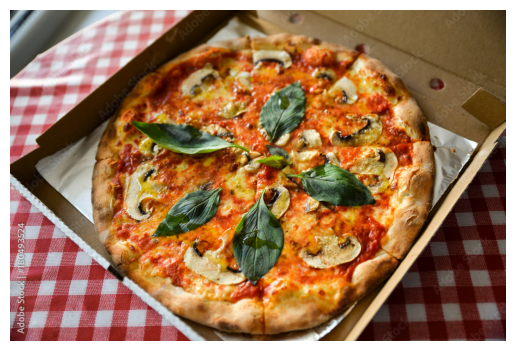

In [119]:
plt.imshow(custom_image_uint8.permute(1, 2, 0));
plt.axis(False);

## Making a prediction on a custom image with a trained PyTorch model

In [162]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

# model_1.eval()
# with torch.inference_mode():
#     model_1(custom_image.to(device))

Custom image tensor:
tensor([[[0.0784, 0.0863, 0.0941,  ..., 0.1882, 0.1882, 0.1804],
         [0.0863, 0.0863, 0.0902,  ..., 0.1922, 0.1843, 0.1804],
         [0.0902, 0.0863, 0.0863,  ..., 0.2000, 0.1922, 0.1843],
         ...,
         [0.2980, 0.3098, 0.3059,  ..., 0.3216, 0.2941, 0.2510],
         [0.2941, 0.3098, 0.3098,  ..., 0.3255, 0.3020, 0.2549],
         [0.2902, 0.3059, 0.3098,  ..., 0.3255, 0.3059, 0.2627]],

        [[0.0980, 0.1059, 0.1137,  ..., 0.1373, 0.1373, 0.1294],
         [0.1059, 0.1059, 0.1098,  ..., 0.1412, 0.1333, 0.1294],
         [0.1020, 0.0980, 0.1059,  ..., 0.1490, 0.1412, 0.1333],
         ...,
         [0.0784, 0.0784, 0.0745,  ..., 0.2784, 0.2314, 0.1608],
         [0.0745, 0.0784, 0.0784,  ..., 0.3020, 0.2549, 0.1922],
         [0.0706, 0.0745, 0.0784,  ..., 0.3059, 0.2627, 0.2039]],

        [[0.1137, 0.1216, 0.1294,  ..., 0.0627, 0.0706, 0.0667],
         [0.1216, 0.1216, 0.1255,  ..., 0.0667, 0.0667, 0.0627],
         [0.1216, 0.1176, 0.1216,  ..

In [163]:
# Create transform pipiline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

custom_image_transformed = custom_image_transform(custom_image)

# Print out the shape
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 668, 1000])
Transformed shape: torch.Size([3, 64, 64])


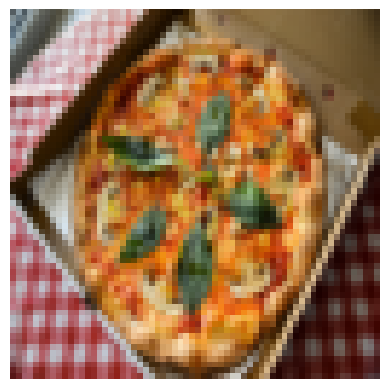

In [164]:
plt.imshow(custom_image_transformed.permute(1, 2, 0));
plt.axis(False);

In [165]:
# Most importantly, batch size should be added

custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [166]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.1624, -1.3835, -0.8267]], device='cuda:0')

In [167]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.6309, 0.1345, 0.2346]], device='cuda:0')

In [168]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label, class_names[custom_image_pred_label]

(tensor([0]), 'pizza')

# Putting Custom image prediction together: building a function
* Ideal outcome:
    `A function we pass an image path to and have our model predict on that image and plot the image + prediction`

In [194]:
def pred_and_plot_image(model, image_path: str, class_names: List[str]=None, transform=None, device=device):
    # Loade the image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # Devide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # Transform if necessary
    if transform:
        target_image = transform(target_image)

    # Make sure the model is on the right device
    model.to(device)

    model.eval()
    with torch.inference_mode():
        # Add extra dimension to the image ( this is the batch size dimension)
        target_image = target_image.unsqueeze(0)

        # Make a prediction on the image with an extra dimension
        target_image_pred = model(target_image.to(device))

    # Convert logits -> pred probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert predictions probs -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.imshow(target_image.squeeze().permute(1,2,0)) # remove batch dimension and rearrange [H, W, CH]
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.2f}%"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);
        

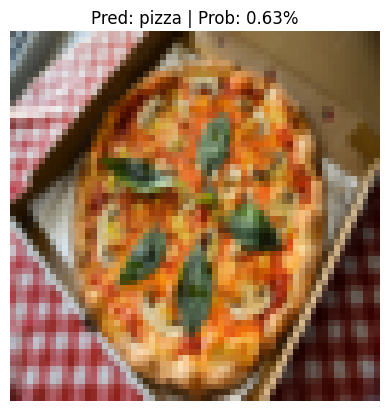

In [195]:
pred_and_plot_image(model_1, image_path=custom_image_path, class_names=class_names, transform=custom_image_transform, device=device)

In [198]:
print("^^Beautiful^^")

^^Beautiful^^
